## Link to the Hugging Face Spaces 
https://huggingface.co/spaces/sbhor/Car_Design_Analysis

In [16]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
torch:  1.13 ; cuda:  1.13.0
detectron2: 0.6


In [21]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from cv2 import imshow
import os
import pandas as pd
import numpy as np
import shutil
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torchvision import transforms
from torchvision import models
import matplotlib.pyplot as plt
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import copy
from sklearn.metrics.pairwise import cosine_similarity
from itertools import product
from tqdm import tqdm
from torch.optim import lr_scheduler
import wandb
import os
import tqdm
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [37]:
df_images_table = pd.read_csv('./Image_table.csv')
#df_images_table = df_images_table.head(40000).copy()

viewpoint_to_label = {45: 0, 0: 1, 270: 2, 180: 3, 225: 4, 135: 5, 90: 6, 315: 7, 360: 8}
df_images_table['Predicted_viewpoint'] = df_images_table['Predicted_viewpoint'].map(viewpoint_to_label)
df_images_table['image_path'] = df_images_table['Image_name'].apply(lambda img_name: '$$'.join(img_name.split('$$')[:4]).replace('$$', '/') + '/' + img_name)
df_images_table['Predicted_viewpoint'] = df_images_table['Predicted_viewpoint'].fillna(0)
df_images_table['Quality_check'] = df_images_table['Quality_check'].fillna(0)
df_images_table['Predicted_viewpoint'] = df_images_table['Predicted_viewpoint'].astype(np.int64)
viewpoints = df_images_table['Predicted_viewpoint'].unique()
print(df_images_table.head())




  Genmodel_ID     Image_ID                                         Image_name  \
0         2_1    2_1$$1$$1  Abarth$$124 Spider$$2017$$Blue$$2_1$$1$$image_...   
1         2_1  2_1$$10$$11  Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...   
2         2_1  2_1$$10$$16  Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...   
3         2_1  2_1$$10$$18  Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...   
4         2_1   2_1$$10$$2  Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...   

   Predicted_viewpoint Quality_check  \
0                    0             0   
1                    0             0   
2                    1             N   
3                    2             0   
4                    3             0   

                                          image_path  
0  Abarth/124 Spider/2017/Blue/Abarth$$124 Spider...  
1  Abarth/124 Spider/2017/Blue/Abarth$$124 Spider...  
2  Abarth/124 Spider/2017/Blue/Abarth$$124 Spider...  
3  Abarth/124 Spider/2017/Blue/Abarth$$124 Spider...

In [38]:
class CarImagesDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 5])
        image = Image.open(img_name)
        viewpoint = self.dataframe.iloc[idx, 3]
        if self.transform:
            image = self.transform(image)
        return image, viewpoint


In [39]:

print(viewpoints)
train_df, test_df = train_test_split(df_images_table, test_size=0.1, shuffle=True, random_state=42)
train_df , val_df = train_test_split(train_df, test_size=0.4, shuffle=True, random_state=42)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = CarImagesDataset(dataframe=train_df, root_dir='./resized_DVM_v2/resized_DVM/', transform=data_transforms['train'])
val_dataset = CarImagesDataset(dataframe=val_df, root_dir='./resized_DVM_v2/resized_DVM/', transform=data_transforms['val'])
test_dataset = CarImagesDataset(dataframe=test_df, root_dir='./resized_DVM_v2/resized_DVM/', transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True,     num_workers=4)
print(f"Train: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")


[0 1 2 3 4 5 6 7 8]
Train: 783963
Validation: 522642
Test: 145179


In [40]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


/home/sbhor/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sbhor/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


In [42]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=20):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []  
    val_losses = []    

    wandb.init(project='car_viewpoint_classification', entity='sbhor')
    wandb.watch(model)

    epochs_no_improve = 0  

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            progress_bar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader), mininterval=60.0)

            for i, (inputs, labels) in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                progress_bar.set_description(
                    f"{phase} Loss: {running_loss/(i+1):.4f} Acc: {running_corrects.double().item()/(inputs.size(0)*(i+1)):.4f}")

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)  
            else:
                val_losses.append(epoch_loss)    

            wandb.log({f'{phase}_loss': epoch_loss, f'{phase}_accuracy': epoch_acc})

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # check for improvement
            if phase == 'val':
                if epoch_acc < best_acc:
                    epochs_no_improve += 1
                    # if no improvement for 'patience' number of epochs, stop training
                    if epochs_no_improve == patience:
                        print('Early stopping!')
                        model.load_state_dict(best_model_wts)
                        return model, train_losses, val_losses
                else:
                    best_acc = epoch_acc
                    epochs_no_improve = 0
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses


In [43]:
model, train_losses, val_losses = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=100,patience=20)
torch.save(model.state_dict(), 'model_viewpoint_full_1e-3.pt')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sbhor. Use `wandb login --relogin` to force relogin


Epoch 0/99
----------


train Loss: 18.9625 Acc: 0.7968: 100%|██████████| 48998/48998 [25:40<00:00, 31.80it/s]

train Loss: 1.1852 Acc: 0.5478



val Loss: 15.9125 Acc: 4.7559: 100%|██████████| 32666/32666 [18:01<00:00, 30.20it/s]


val Loss: 0.9946 Acc: 0.5945

Epoch 1/99
----------


train Loss: 18.0528 Acc: 0.8155: 100%|██████████| 48998/48998 [24:54<00:00, 32.79it/s]

train Loss: 1.1283 Acc: 0.5607



val Loss: 15.7622 Acc: 4.7220: 100%|██████████| 32666/32666 [17:32<00:00, 31.04it/s]

val Loss: 0.9852 Acc: 0.5903

Epoch 2/99
----------



train Loss: 17.7737 Acc: 0.8235: 100%|██████████| 48998/48998 [24:57<00:00, 32.71it/s]

train Loss: 1.1109 Acc: 0.5662



val Loss: 15.6186 Acc: 4.8409: 100%|██████████| 32666/32666 [17:38<00:00, 30.87it/s]

val Loss: 0.9762 Acc: 0.6051

Epoch 3/99
----------



train Loss: 17.5943 Acc: 0.8269: 100%|██████████| 48998/48998 [24:55<00:00, 32.76it/s]

train Loss: 1.0997 Acc: 0.5685



val Loss: 15.2444 Acc: 4.8764: 100%|██████████| 32666/32666 [17:32<00:00, 31.03it/s]

val Loss: 0.9528 Acc: 0.6096

Epoch 4/99
----------



train Loss: 17.4462 Acc: 0.8307: 100%|██████████| 48998/48998 [24:53<00:00, 32.81it/s]

train Loss: 1.0904 Acc: 0.5711



val Loss: 15.2951 Acc: 4.8628: 100%|██████████| 32666/32666 [17:39<00:00, 30.83it/s]

val Loss: 0.9560 Acc: 0.6079

Epoch 5/99
----------



train Loss: 17.3523 Acc: 0.8327: 100%|██████████| 48998/48998 [24:49<00:00, 32.89it/s]

train Loss: 1.0845 Acc: 0.5725



val Loss: 15.1460 Acc: 4.8953: 100%|██████████| 32666/32666 [17:34<00:00, 30.97it/s]

val Loss: 0.9467 Acc: 0.6119

Epoch 6/99
----------



train Loss: 17.2610 Acc: 0.8357: 100%|██████████| 48998/48998 [24:57<00:00, 32.72it/s]

train Loss: 1.0788 Acc: 0.5746



val Loss: 15.0440 Acc: 4.9205: 100%|██████████| 32666/32666 [17:31<00:00, 31.07it/s]

val Loss: 0.9403 Acc: 0.6151

Epoch 7/99
----------



train Loss: 17.0310 Acc: 0.8444: 100%|██████████| 48998/48998 [25:05<00:00, 32.54it/s]

train Loss: 1.0644 Acc: 0.5805



val Loss: 14.8603 Acc: 4.9308: 100%|██████████| 32666/32666 [17:32<00:00, 31.03it/s]

val Loss: 0.9288 Acc: 0.6164

Epoch 8/99
----------



train Loss: 17.0211 Acc: 0.8456: 100%|██████████| 48998/48998 [24:50<00:00, 32.88it/s]

train Loss: 1.0638 Acc: 0.5813



val Loss: 14.8878 Acc: 4.9278: 100%|██████████| 32666/32666 [17:33<00:00, 31.00it/s]

val Loss: 0.9305 Acc: 0.6160

Epoch 9/99
----------



train Loss: 17.0177 Acc: 0.8447: 100%|██████████| 48998/48998 [24:50<00:00, 32.88it/s]

train Loss: 1.0636 Acc: 0.5808



val Loss: 14.8229 Acc: 4.9398: 100%|██████████| 32666/32666 [17:32<00:00, 31.04it/s]

val Loss: 0.9265 Acc: 0.6175

Epoch 10/99
----------



train Loss: 16.9901 Acc: 0.8468: 100%|██████████| 48998/48998 [24:50<00:00, 32.86it/s]

train Loss: 1.0619 Acc: 0.5822



val Loss: 14.8818 Acc: 4.9388: 100%|██████████| 32666/32666 [17:32<00:00, 31.02it/s]

val Loss: 0.9301 Acc: 0.6174

Epoch 11/99
----------



train Loss: 16.9990 Acc: 0.8461: 100%|██████████| 48998/48998 [24:52<00:00, 32.83it/s]

train Loss: 1.0624 Acc: 0.5817



val Loss: 14.9039 Acc: 4.9292: 100%|██████████| 32666/32666 [17:32<00:00, 31.04it/s]

val Loss: 0.9315 Acc: 0.6162

Epoch 12/99
----------



train Loss: 16.9795 Acc: 0.8469: 100%|██████████| 48998/48998 [25:00<00:00, 32.66it/s]

train Loss: 1.0612 Acc: 0.5823



val Loss: 14.8394 Acc: 4.9481: 100%|██████████| 32666/32666 [17:34<00:00, 30.96it/s]

val Loss: 0.9275 Acc: 0.6185

Epoch 13/99
----------



train Loss: 16.9593 Acc: 0.8473: 100%|██████████| 48998/48998 [24:55<00:00, 32.76it/s]

train Loss: 1.0600 Acc: 0.5825



val Loss: 14.8378 Acc: 4.9543: 100%|██████████| 32666/32666 [17:33<00:00, 31.01it/s]

val Loss: 0.9274 Acc: 0.6193

Epoch 14/99
----------



train Loss: 16.9613 Acc: 0.8475: 100%|██████████| 48998/48998 [24:55<00:00, 32.76it/s]

train Loss: 1.0601 Acc: 0.5826



val Loss: 14.8149 Acc: 4.9434: 100%|██████████| 32666/32666 [17:36<00:00, 30.93it/s]

val Loss: 0.9260 Acc: 0.6179

Epoch 15/99
----------



train Loss: 16.9618 Acc: 0.8480: 100%|██████████| 48998/48998 [25:09<00:00, 32.45it/s]

train Loss: 1.0601 Acc: 0.5830



val Loss: 14.8568 Acc: 4.9387: 100%|██████████| 32666/32666 [17:44<00:00, 30.70it/s]

val Loss: 0.9286 Acc: 0.6174

Epoch 16/99
----------



train Loss: 16.9459 Acc: 0.8472: 100%|██████████| 48998/48998 [25:06<00:00, 32.53it/s]

train Loss: 1.0591 Acc: 0.5824



val Loss: 14.9013 Acc: 4.9415: 100%|██████████| 32666/32666 [17:38<00:00, 30.86it/s]

val Loss: 0.9314 Acc: 0.6177

Epoch 17/99
----------



train Loss: 16.9604 Acc: 0.8481: 100%|██████████| 48998/48998 [24:49<00:00, 32.90it/s]

train Loss: 1.0600 Acc: 0.5831



val Loss: 14.8388 Acc: 4.9295: 100%|██████████| 32666/32666 [17:46<00:00, 30.62it/s]

val Loss: 0.9275 Acc: 0.6162

Epoch 18/99
----------



train Loss: 16.9611 Acc: 0.8476: 100%|██████████| 48998/48998 [24:54<00:00, 32.78it/s]

train Loss: 1.0601 Acc: 0.5827



val Loss: 14.8060 Acc: 4.9509: 100%|██████████| 32666/32666 [17:35<00:00, 30.95it/s]

val Loss: 0.9254 Acc: 0.6189

Epoch 19/99
----------



train Loss: 16.9450 Acc: 0.8479: 100%|██████████| 48998/48998 [24:53<00:00, 32.80it/s]

train Loss: 1.0591 Acc: 0.5830



val Loss: 14.8763 Acc: 4.9344: 100%|██████████| 32666/32666 [17:35<00:00, 30.94it/s]

val Loss: 0.9298 Acc: 0.6168

Epoch 20/99
----------



train Loss: 16.9355 Acc: 0.8477: 100%|██████████| 48998/48998 [24:56<00:00, 32.74it/s]

train Loss: 1.0585 Acc: 0.5828



val Loss: 14.8494 Acc: 4.9422: 100%|██████████| 32666/32666 [17:36<00:00, 30.93it/s]

val Loss: 0.9281 Acc: 0.6178

Epoch 21/99
----------



train Loss: 16.9481 Acc: 0.8482: 100%|██████████| 48998/48998 [24:52<00:00, 32.83it/s]

train Loss: 1.0593 Acc: 0.5831



val Loss: 14.8399 Acc: 4.9295: 100%|██████████| 32666/32666 [17:37<00:00, 30.89it/s]

val Loss: 0.9275 Acc: 0.6162

Epoch 22/99
----------



train Loss: 16.9413 Acc: 0.8484: 100%|██████████| 48998/48998 [25:04<00:00, 32.56it/s]

train Loss: 1.0588 Acc: 0.5832



val Loss: 14.9526 Acc: 4.9122: 100%|██████████| 32666/32666 [17:39<00:00, 30.82it/s]

val Loss: 0.9346 Acc: 0.6140

Epoch 23/99
----------



train Loss: 16.9515 Acc: 0.8485: 100%|██████████| 48998/48998 [25:01<00:00, 32.63it/s]

train Loss: 1.0595 Acc: 0.5834



val Loss: 14.8157 Acc: 4.9358: 100%|██████████| 32666/32666 [17:38<00:00, 30.87it/s]

val Loss: 0.9260 Acc: 0.6170

Epoch 24/99
----------



train Loss: 16.9493 Acc: 0.8485: 100%|██████████| 48998/48998 [25:02<00:00, 32.60it/s]

train Loss: 1.0593 Acc: 0.5834



val Loss: 14.8331 Acc: 4.9460: 100%|██████████| 32666/32666 [17:44<00:00, 30.70it/s]

val Loss: 0.9271 Acc: 0.6183

Epoch 25/99
----------



train Loss: 16.9532 Acc: 0.8479: 100%|██████████| 48998/48998 [25:09<00:00, 32.46it/s]

train Loss: 1.0596 Acc: 0.5829



val Loss: 14.7968 Acc: 4.9587: 100%|██████████| 32666/32666 [17:40<00:00, 30.81it/s]

val Loss: 0.9248 Acc: 0.6199

Epoch 26/99
----------



train Loss: 16.9633 Acc: 0.8475: 100%|██████████| 48998/48998 [25:03<00:00, 32.58it/s]

train Loss: 1.0602 Acc: 0.5827



val Loss: 14.8965 Acc: 4.9287: 100%|██████████| 32666/32666 [17:41<00:00, 30.78it/s]

val Loss: 0.9311 Acc: 0.6161

Epoch 27/99
----------



train Loss: 16.9598 Acc: 0.8485: 100%|██████████| 48998/48998 [30:46<00:00, 26.53it/s]

train Loss: 1.0600 Acc: 0.5833



val Loss: 14.8585 Acc: 4.9390: 100%|██████████| 32666/32666 [20:42<00:00, 26.29it/s]

val Loss: 0.9287 Acc: 0.6174

Epoch 28/99
----------



train Loss: 16.9419 Acc: 0.8489: 100%|██████████| 48998/48998 [37:37<00:00, 21.71it/s]

train Loss: 1.0589 Acc: 0.5836



val Loss: 14.8316 Acc: 4.9433: 100%|██████████| 32666/32666 [20:19<00:00, 26.79it/s]

val Loss: 0.9270 Acc: 0.6179

Epoch 29/99
----------



train Loss: 16.9416 Acc: 0.8482: 100%|██████████| 48998/48998 [25:09<00:00, 32.45it/s]

train Loss: 1.0589 Acc: 0.5832



val Loss: 14.8773 Acc: 4.9439: 100%|██████████| 32666/32666 [17:40<00:00, 30.80it/s]

val Loss: 0.9299 Acc: 0.6180

Epoch 30/99
----------



train Loss: 16.9558 Acc: 0.8483: 100%|██████████| 48998/48998 [25:14<00:00, 32.36it/s]

train Loss: 1.0597 Acc: 0.5832



val Loss: 14.8021 Acc: 4.9537: 100%|██████████| 32666/32666 [17:43<00:00, 30.72it/s]

val Loss: 0.9252 Acc: 0.6192

Epoch 31/99
----------



train Loss: 16.9613 Acc: 0.8478: 100%|██████████| 48998/48998 [25:11<00:00, 32.42it/s]

train Loss: 1.0601 Acc: 0.5829



val Loss: 14.8192 Acc: 4.9259: 100%|██████████| 32666/32666 [17:48<00:00, 30.58it/s]

val Loss: 0.9262 Acc: 0.6158

Epoch 32/99
----------



train Loss: 16.9614 Acc: 0.8480: 100%|██████████| 48998/48998 [25:20<00:00, 32.22it/s]

train Loss: 1.0601 Acc: 0.5830



val Loss: 14.8689 Acc: 4.9383: 100%|██████████| 32666/32666 [17:49<00:00, 30.54it/s]

val Loss: 0.9293 Acc: 0.6173

Epoch 33/99
----------



train Loss: 16.9521 Acc: 0.8475: 100%|██████████| 48998/48998 [25:58<00:00, 31.43it/s]

train Loss: 1.0595 Acc: 0.5827



val Loss: 14.8546 Acc: 4.9409: 100%|██████████| 32666/32666 [18:04<00:00, 30.12it/s]

val Loss: 0.9284 Acc: 0.6176

Epoch 34/99
----------



train Loss: 16.9440 Acc: 0.8487: 100%|██████████| 48998/48998 [25:38<00:00, 31.85it/s]

train Loss: 1.0590 Acc: 0.5835



val Loss: 14.8098 Acc: 4.9392: 100%|██████████| 32666/32666 [17:48<00:00, 30.56it/s]


val Loss: 0.9256 Acc: 0.6174

Epoch 35/99
----------


train Loss: 16.9429 Acc: 0.8487: 100%|██████████| 48998/48998 [25:10<00:00, 32.44it/s]

train Loss: 1.0589 Acc: 0.5835



val Loss: 14.8017 Acc: 4.9324: 100%|██████████| 32666/32666 [17:37<00:00, 30.88it/s]

val Loss: 0.9251 Acc: 0.6166

Epoch 36/99
----------



train Loss: 16.9488 Acc: 0.8493: 100%|██████████| 48998/48998 [25:02<00:00, 32.61it/s]

train Loss: 1.0593 Acc: 0.5839



val Loss: 14.8056 Acc: 4.9494: 100%|██████████| 32666/32666 [17:34<00:00, 30.99it/s]

val Loss: 0.9254 Acc: 0.6187

Epoch 37/99
----------



train Loss: 16.9469 Acc: 0.8479: 100%|██████████| 48998/48998 [24:58<00:00, 32.70it/s]

train Loss: 1.0592 Acc: 0.5830



val Loss: 14.8415 Acc: 4.9498: 100%|██████████| 32666/32666 [17:34<00:00, 30.98it/s]

val Loss: 0.9276 Acc: 0.6187

Epoch 38/99
----------



train Loss: 16.9416 Acc: 0.8483: 100%|██████████| 48998/48998 [24:55<00:00, 32.77it/s]

train Loss: 1.0589 Acc: 0.5832



val Loss: 14.8104 Acc: 4.9386: 100%|██████████| 32666/32666 [17:35<00:00, 30.95it/s]

val Loss: 0.9257 Acc: 0.6173

Epoch 39/99
----------



train Loss: 16.9552 Acc: 0.8486: 100%|██████████| 48998/48998 [24:54<00:00, 32.78it/s]

train Loss: 1.0597 Acc: 0.5834



val Loss: 14.7852 Acc: 4.9581: 100%|██████████| 32666/32666 [17:34<00:00, 30.97it/s]

val Loss: 0.9241 Acc: 0.6198

Epoch 40/99
----------



train Loss: 16.9487 Acc: 0.8485: 100%|██████████| 48998/48998 [24:53<00:00, 32.82it/s]

train Loss: 1.0593 Acc: 0.5834



val Loss: 14.8188 Acc: 4.9296: 100%|██████████| 32666/32666 [17:34<00:00, 30.98it/s]

val Loss: 0.9262 Acc: 0.6162

Epoch 41/99
----------



train Loss: 16.9499 Acc: 0.8477: 100%|██████████| 48998/48998 [24:56<00:00, 32.75it/s]

train Loss: 1.0594 Acc: 0.5828



val Loss: 14.8509 Acc: 4.9448: 100%|██████████| 32666/32666 [17:35<00:00, 30.96it/s]

val Loss: 0.9282 Acc: 0.6181

Epoch 42/99
----------



train Loss: 16.9450 Acc: 0.8485: 100%|██████████| 48998/48998 [24:58<00:00, 32.71it/s]

train Loss: 1.0591 Acc: 0.5833



val Loss: 14.7732 Acc: 4.9518: 100%|██████████| 32666/32666 [17:35<00:00, 30.95it/s]

val Loss: 0.9233 Acc: 0.6190

Epoch 43/99
----------



train Loss: 16.9732 Acc: 0.8475: 100%|██████████| 48998/48998 [24:54<00:00, 32.79it/s]

train Loss: 1.0608 Acc: 0.5826



val Loss: 14.8812 Acc: 4.9493: 100%|██████████| 32666/32666 [17:34<00:00, 30.99it/s]

val Loss: 0.9301 Acc: 0.6187

Epoch 44/99
----------



train Loss: 16.9327 Acc: 0.8485: 100%|██████████| 48998/48998 [24:54<00:00, 32.78it/s]

train Loss: 1.0583 Acc: 0.5834



val Loss: 14.8351 Acc: 4.9372: 100%|██████████| 32666/32666 [17:34<00:00, 30.97it/s]

val Loss: 0.9272 Acc: 0.6172

Epoch 45/99
----------



train Loss: 16.9524 Acc: 0.8484: 100%|██████████| 48998/48998 [24:59<00:00, 32.67it/s]

train Loss: 1.0595 Acc: 0.5833



val Loss: 14.8659 Acc: 4.9348: 100%|██████████| 32666/32666 [17:42<00:00, 30.75it/s]

val Loss: 0.9291 Acc: 0.6169
Early stopping!


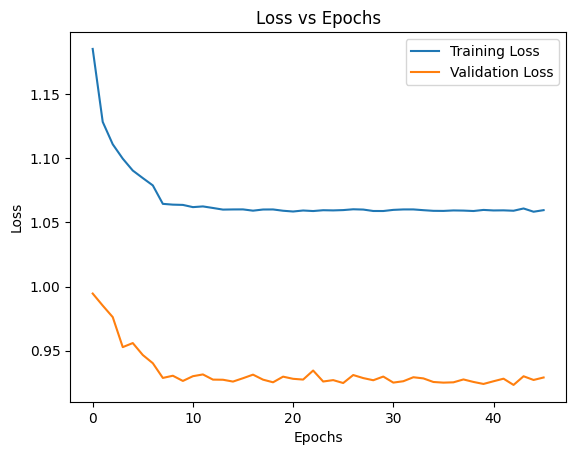

In [44]:
plot1, = plt.plot(train_losses, label='Training Loss')
plot2, = plt.plot(val_losses, label='Validation Loss')
plt.legend(handles=[plot1, plot2])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.savefig('loss_vs_epochs.png')
plt.show()

In [45]:
def test_model(model, criterion, dataloader, num_images=25):
    model.eval()  

    running_loss = 0.0
    running_corrects = 0

    progress_bar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader))

    test_images = []
    true_labels = []
    predictions = []

    # Iterate over data
    for i, (inputs, labels) in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        progress_bar.set_description(
            f"Test Loss: {running_loss/(i+1):.4f} Acc: {running_corrects.double().item()/(inputs.size(0)*(i+1)):.4f}")

        if i == 0:
            test_images.extend(inputs[:num_images])
            true_labels.extend(labels[:num_images])
            predictions.extend(preds[:num_images])

    total_loss = running_loss / len(dataloader.dataset)
    total_acc = running_corrects.double() / len(dataloader.dataset)

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(total_loss, total_acc))

    # Convert lists of test images, true labels, and predictions to tensors for further use
    test_images = torch.stack(test_images)
    true_labels = torch.stack(true_labels)
    predictions = torch.stack(predictions)

    return total_loss, total_acc, test_images, true_labels, predictions


In [46]:
total_loss, total_acc, test_images, true_labels, predictions  = test_model(model, criterion, test_loader)
print(f"Test Loss: {total_loss:.4f} Test Accuracy: {total_acc:.4f}")

Test Loss: 14.7619 Acc: 0.9033: 100%|██████████| 9074/9074 [12:42<00:00, 11.90it/s]


Test Loss: 0.9226 Acc: 0.6210
Test Loss: 0.9226 Test Accuracy: 0.6210


In [47]:
class_names = ['45', '0', '270', '180', '225', '135', '90', '315', '360']
def show_images(images, labels, preds):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(images):
        plt.subplot(5, 5, i + 1, xticks=[], yticks=[])
        image = image.to('cpu')
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green' if preds[i] == labels[i] else 'red'
        plt.xlabel(f'{class_names[preds[i]]}')
        plt.ylabel(f'{class_names[labels[i]]}', color=col)
    plt.tight_layout()
    plt.show()



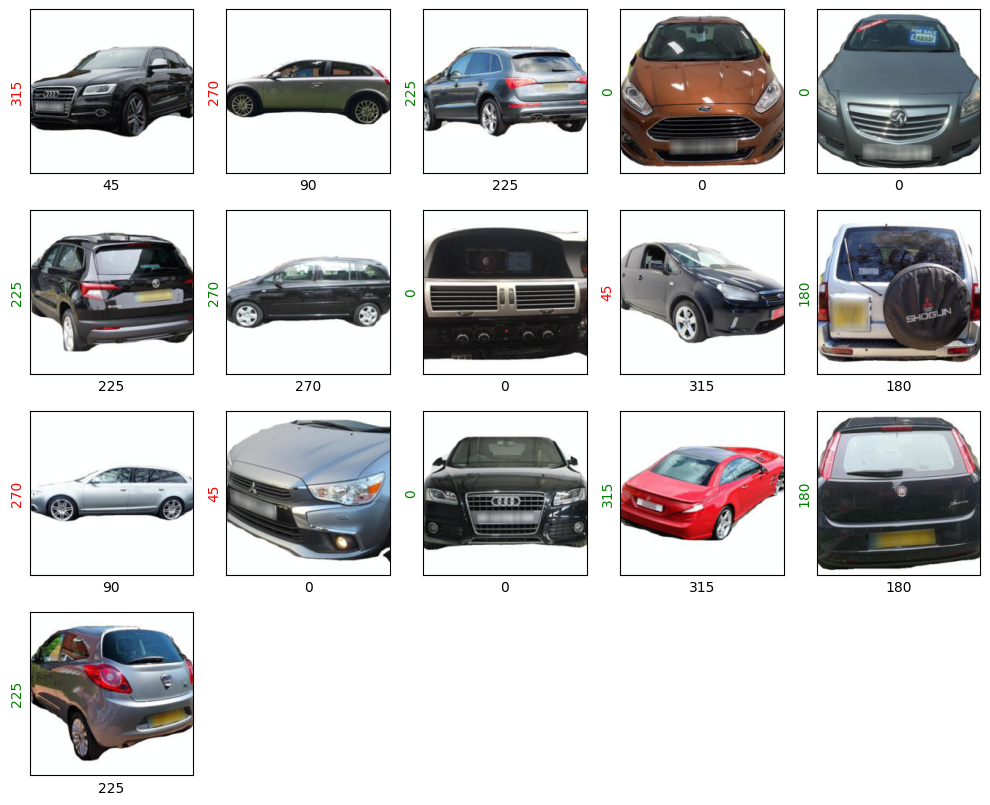

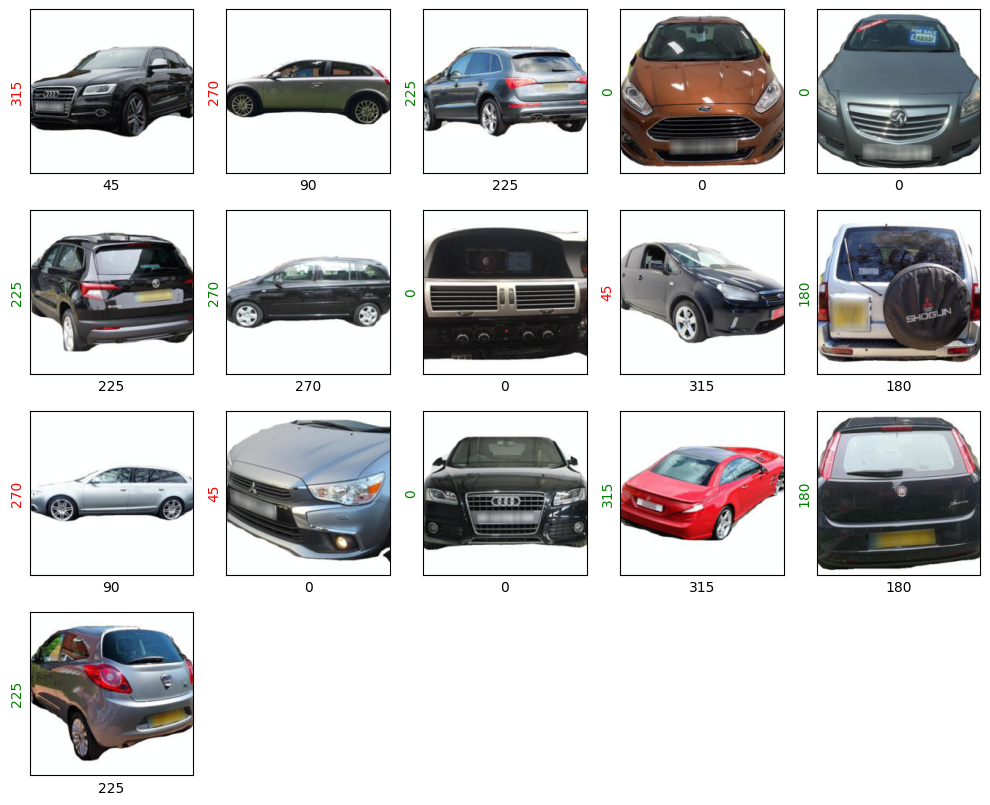

In [48]:
show_images(test_images, true_labels, predictions)
inputs = test_images[:25]
labels = true_labels[:25]
preds = predictions[:25]
show_images(inputs, labels, preds)

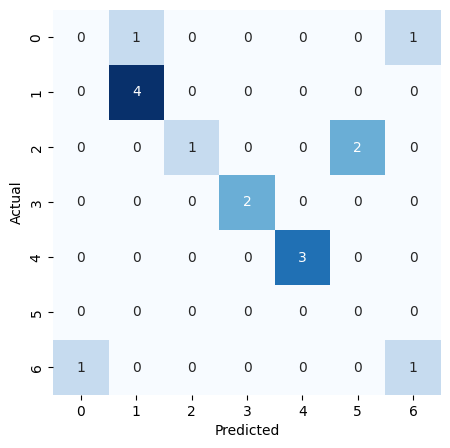

In [49]:
cm = confusion_matrix(true_labels.to('cpu'), predictions.to('cpu'))
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()